In [39]:
import pandas as pd
import numpy as np
from time import time
import json
from sqlalchemy import create_engine
import re
import datetime
from mpl_toolkits.basemap import Basemap

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('seaborn-whitegrid')
import numpy as np
from mpl_toolkits.basemap import Basemap
from geopy.distance import distance as dist
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import folium

In [40]:
# Set up the SQL connection
dbname = 'redshift'
url = 'panamera-ods.cnsuxis6zqxr.us-west-2.redshift.amazonaws.com:5439/panameraods'
engine = create_engine("postgresql://" + 'lucasdresl' + ":" + 'cQsY801a76x82x62aWDT' + "@" + url)


In [41]:
query = """

-- SELECCION DE DATA DEL AB TEST

;drop table if exists tabla1;
      select  meta_session_long,
              params_test_name,
              params_test_variation as variation,
              min(to_date(TIMESTAMP 'epoch' + meta_date::int * INTERVAL '1 second','YYYY-MM-DD')) as first_exposition
       into temp table tabla1
      from spectrum.hydra_p_olx_android
      where params_cc like '%in%'
      and params_en='test_impression'
      and params_test_name like 'pan-30229'
      and params_test_variation is not null
            and year=2019
      and month=11
      group by 1,2,3


;drop table if exists tabla2;
select  a.meta_session_long,
       a.params_test_name,
       a.variation,
       a.first_exposition ,
       b.date_event_nk ,
       b.params_test_variation,
       count(distinct case when b.params_test_variation is not null then b.meta_session_long
               else null end) as count_dups
    into temp tabla2
 from tabla1 as a
left join
       (select meta_session_long,to_date(TIMESTAMP 'epoch' + meta_date::int * INTERVAL '1 second','YYYY-MM-DD') as date_event_nk,params_test_variation
       from spectrum.hydra_p_olx_android
       where params_cc like '%in%'
      and params_en='test_impression'
      and params_test_name like 'pan-31472'
      and params_test_variation is not null
      and year=2019
      and month=11) as b
on a.meta_session_long=b.meta_session_long and b.date_event_nk>=first_exposition and a.variation != b.params_test_variation
group by 1,2,3,4,5,6

-- SACO USUARIOS EXPUESTOS EN AMBAS VARIANTES

;drop table if exists no_duplicates;
select
*
 into temp table no_duplicates
from tabla2
where count_dups=0

-- DAU

;drop table if exists dau;
select
 session_long,
 date_event_nk,
 b.first_exposition,
 b.variation
   into temp table dau
  from ods.panameraolx_asia_hydra_ninja_android_last_month a
   join (select meta_session_long, first_exposition,variation from no_duplicates group by 1,2,3) b on a.session_long=b.meta_session_long and a.date_event_nk>b.first_exposition
where
    country_sk='olx|asia|in'
 and ((trackevent NOT IN ('app_open', 'on_create', 'apps', 'push_dis','pushDis', 'push_rcv', 'pushRcv', 'UAReg', 'ua_reg', 'uareg','push_dismissed', 'push_show', 'fetching_matrix', 'not_found','permissions_impression','userBadgeCount','test_assignment','test_impression','test_discovered','FCMReg','APNSReg','appOpn','appOpen','google_play_services','fetchTestDefinitionsError','messages_scheduler_ended','messages_scheduler_started','chat_auth_fail','item_chat_multi_delete') AND trackevent IS NOT NULL AND trackevent NOT LIKE 'b2c%'))
group by 1,2,3,4

-- DUB

;drop table if exists dub;
select
 session_long,
 date_event_nk
   into temp table dub
  from ods.panameraolx_asia_hydra_ninja_android_last_month a
   join (select meta_session_long, first_exposition,variation from no_duplicates group by 1,2,3) b on a.session_long=b.meta_session_long and a.date_event_nk>b.first_exposition
where
    country_sk='olx|asia|in'
 and trackevent in ('item_tap_call' , 'item_chat_tap_send_1st_reply' , 'item_tap_sms' , 'item_chat_tap_sms')
group by 1,2

-- DAU AND DUB

;drop table if exists dau_dub;
select
  a.*,
  case when b.date_event_nk is not null then 1 else 0 end as dub
   into temp table dau_dub
 from dau a
  left join dub b on a.session_long=b.session_long and a.date_event_nk=b.date_event_nk;

select
 date_event_nk,
 variation,
 count(distinct session_long) as dau,
 sum(dub) as dub
from dau_dub
group by 1,2

"""


In [42]:
df = pd.read_sql_query(query.replace('%', '%%'), engine)

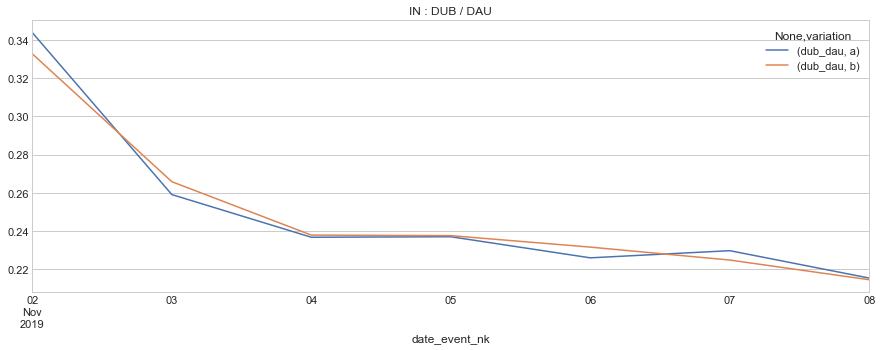

In [43]:
df['dub_dau'] = df['dub'] / df['dau']
dft = df.set_index(['date_event_nk' , 'variation'])
dft[['dub_dau']].unstack().plot(figsize=(15,5) , title='IN : DUB / DAU')

Difference B vs A : 0.18%


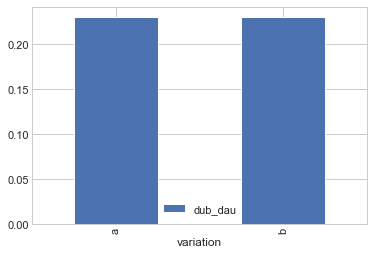

In [50]:
result = df.pivot_table(index='variation' , values=['dau' , 'dub'] , aggfunc='sum')
result['dub_dau'] = result['dub'] / result['dau']
print('Difference B vs A : ' + str(round(((result.iloc[1,2] - result.iloc[0,2]) / result.iloc[0,2]) , 4)*100) + '%')
result[['dub_dau']].plot(kind='bar')

In [45]:
result

,dau,dub,dub_dau
variation,,,
a,93400,21490,0.230086
b,282533,65124,0.230501


In [61]:
query = """

-- SELECCION DE DATA DEL AB TEST

;drop table if exists tabla1;
      select  meta_session_long,
              params_test_name,
              params_test_variation as variation,
              min(to_date(TIMESTAMP 'epoch' + meta_date::int * INTERVAL '1 second','YYYY-MM-DD')) as first_exposition
       into temp table tabla1
      from spectrum.hydra_p_olx_android
      where params_cc like '%in%'
      and params_en='test_impression'
      and params_test_name like 'pan-30229'
      and params_test_variation is not null
            and year=2019
      and month=11
      group by 1,2,3


;drop table if exists tabla2;
select  a.meta_session_long,
       a.params_test_name,
       a.variation,
       a.first_exposition ,
       b.date_event_nk ,
       b.params_test_variation,
       count(distinct case when b.params_test_variation is not null then b.meta_session_long
               else null end) as count_dups
    into temp tabla2
 from tabla1 as a
left join
       (select meta_session_long,to_date(TIMESTAMP 'epoch' + meta_date::int * INTERVAL '1 second','YYYY-MM-DD') as date_event_nk,params_test_variation
       from spectrum.hydra_p_olx_android
       where params_cc like '%in%'
      and params_en='test_impression'
      and params_test_name like 'pan-31472'
      and params_test_variation is not null
      and year=2019
      and month=11) as b
on a.meta_session_long=b.meta_session_long and b.date_event_nk>=first_exposition and a.variation != b.params_test_variation
group by 1,2,3,4,5,6

-- SACO USUARIOS EXPUESTOS EN AMBAS VARIANTES

;drop table if exists no_duplicates;
select
*
 into temp table no_duplicates
from tabla2
where count_dups=0

-- DAU

;drop table if exists dau;
select
 session_long,
 date_event_nk,
 b.first_exposition,
 b.variation
   into temp table dau
  from ods.panameraolx_asia_hydra_ninja_android_last_month a
   join (select meta_session_long, first_exposition,variation from no_duplicates group by 1,2,3) b on a.session_long=b.meta_session_long and a.date_event_nk>b.first_exposition
where
    country_sk='olx|asia|in'
 and ((trackevent NOT IN ('app_open', 'on_create', 'apps', 'push_dis','pushDis', 'push_rcv', 'pushRcv', 'UAReg', 'ua_reg', 'uareg','push_dismissed', 'push_show', 'fetching_matrix', 'not_found','permissions_impression','userBadgeCount','test_assignment','test_impression','test_discovered','FCMReg','APNSReg','appOpn','appOpen','google_play_services','fetchTestDefinitionsError','messages_scheduler_ended','messages_scheduler_started','chat_auth_fail','item_chat_multi_delete') AND trackevent IS NOT NULL AND trackevent NOT LIKE 'b2c%'))
group by 1,2,3,4

-- DUB

;drop table if exists dub;
select
 session_long,
 date_event_nk,
 listing_sk,
 user_sk
   into temp table dub
  from ods.panameraolx_asia_hydra_ninja_android_last_month a
   join (select meta_session_long, first_exposition,variation from no_duplicates group by 1,2,3) b on a.session_long=b.meta_session_long and a.date_event_nk>b.first_exposition
where
    country_sk='olx|asia|in'
 and trackevent in ('item_tap_call' , 'item_chat_tap_send_1st_reply' , 'item_tap_sms' , 'item_chat_tap_sms')
group by 1,2,3,4

-- Meaningful conversation

;drop table if exists mc;
select 
 date_sent_1st_msg_nk,
 buyer_sk,
 listing_sk
  into temp table mc
   from ods.fact_conversations_daily
where country_sk='olx|asia|in'
 and interaction_num_in_conv=6
 and conv_init_by_buyer is true 
 and date_sent_1st_msg_nk>'2019-09-01'
group by 1,2,3

;drop table if exists mc2;
select 
  a.*
  into temp table mc2
  from mc a
 join (select user_sk , listing_sk , session_long from dub group by 1,2,3) b ON a.buyer_sk=b.user_sk and a.listing_sk=b.listing_sk



-- DAU AND DUB AND MC

;drop table if exists dau_dub;
select
  a.*,
  case when b.date_event_nk is not null then 1 else 0 end as dub,
  case when c.date_sent_1st_msg_nk is not null then 1 else 0 end as mc
   into temp table dau_dub
 from dau a
  left join dub b on a.session_long=b.session_long and a.date_event_nk=b.date_event_nk
  left join mc2 c on a.session_long=c.session_long and a.date_event_nk=c.date_sent_1st_msg_nk
  group by 1,2,3,4,5,6
  ;

select
 date_event_nk,
 variation,
 count(distinct session_long) as dau,
 sum(dub) as dub,
 sum(mc) as mc
from dau_dub
group by 1,2

"""


In [62]:
mc = pd.read_sql_query(query.replace('%', '%%'), engine)

OperationalError: (psycopg2.errors.QueryCanceled) Query (42325397) canceled on user's request and ran out of wlm queues for restart.

[SQL: 

-- SELECCION DE DATA DEL AB TEST

;drop table if exists tabla1;
      select  meta_session_long,
              params_test_name,
              params_test_variation as variation,
              min(to_date(TIMESTAMP 'epoch' + meta_date::int * INTERVAL '1 second','YYYY-MM-DD')) as first_exposition
       into temp table tabla1
      from spectrum.hydra_p_olx_android
      where params_cc like '%%in%%'
      and params_en='test_impression'
      and params_test_name like 'pan-30229'
      and params_test_variation is not null
            and year=2019
      and month=11
      group by 1,2,3


;drop table if exists tabla2;
select  a.meta_session_long,
       a.params_test_name,
       a.variation,
       a.first_exposition ,
       b.date_event_nk ,
       b.params_test_variation,
       count(distinct case when b.params_test_variation is not null then b.meta_session_long
               else null end) as count_dups
    into temp tabla2
 from tabla1 as a
left join
       (select meta_session_long,to_date(TIMESTAMP 'epoch' + meta_date::int * INTERVAL '1 second','YYYY-MM-DD') as date_event_nk,params_test_variation
       from spectrum.hydra_p_olx_android
       where params_cc like '%%in%%'
      and params_en='test_impression'
      and params_test_name like 'pan-31472'
      and params_test_variation is not null
      and year=2019
      and month=11) as b
on a.meta_session_long=b.meta_session_long and b.date_event_nk>=first_exposition and a.variation != b.params_test_variation
group by 1,2,3,4,5,6

-- SACO USUARIOS EXPUESTOS EN AMBAS VARIANTES

;drop table if exists no_duplicates;
select
*
 into temp table no_duplicates
from tabla2
where count_dups=0

-- DAU

;drop table if exists dau;
select
 session_long,
 date_event_nk,
 b.first_exposition,
 b.variation
   into temp table dau
  from ods.panameraolx_asia_hydra_ninja_android_last_month a
   join (select meta_session_long, first_exposition,variation from no_duplicates group by 1,2,3) b on a.session_long=b.meta_session_long and a.date_event_nk>b.first_exposition
where
    country_sk='olx|asia|in'
 and ((trackevent NOT IN ('app_open', 'on_create', 'apps', 'push_dis','pushDis', 'push_rcv', 'pushRcv', 'UAReg', 'ua_reg', 'uareg','push_dismissed', 'push_show', 'fetching_matrix', 'not_found','permissions_impression','userBadgeCount','test_assignment','test_impression','test_discovered','FCMReg','APNSReg','appOpn','appOpen','google_play_services','fetchTestDefinitionsError','messages_scheduler_ended','messages_scheduler_started','chat_auth_fail','item_chat_multi_delete') AND trackevent IS NOT NULL AND trackevent NOT LIKE 'b2c%%'))
group by 1,2,3,4

-- DUB

;drop table if exists dub;
select
 session_long,
 date_event_nk,
 listing_sk,
 user_sk
   into temp table dub
  from ods.panameraolx_asia_hydra_ninja_android_last_month a
   join (select meta_session_long, first_exposition,variation from no_duplicates group by 1,2,3) b on a.session_long=b.meta_session_long and a.date_event_nk>b.first_exposition
where
    country_sk='olx|asia|in'
 and trackevent in ('item_tap_call' , 'item_chat_tap_send_1st_reply' , 'item_tap_sms' , 'item_chat_tap_sms')
group by 1,2,3,4

-- Meaningful conversation

;drop table if exists mc;
select
 date_sent_1st_msg_nk,
 session_long
   into temp table mc
from ods.fact_conversations_daily a
  join (select user_sk , listing_sk , session_long from dub group by 1,2,3) b ON a.buyer_sk=b.user_sk and a.listing_sk=b.listing_sk
where country_sk='olx|asia|in'
  and interaction_num_in_conv = 6
  and conv_init_by_buyer is true
group by 1,2


-- DAU AND DUB AND MC

;drop table if exists dau_dub;
select
  a.*,
  case when b.date_event_nk is not null then 1 else 0 end as dub,
  case when c.date_sent_1st_msg_nk is not null then 1 else 0 end as mc
   into temp table dau_dub
 from dau a
  left join dub b on a.session_long=b.session_long and a.date_event_nk=b.date_event_nk
  left join mc c on a.session_long=c.session_long and a.date_event_nk=c.date_sent_1st_msg_nk
  ;

select
 date_event_nk,
 variation,
 count(distinct session_long) as dau,
 sum(dub) as dub,
 sum(mc) as mc
from dau_dub
group by 1,2

]
(Background on this error at: http://sqlalche.me/e/e3q8)

In [ ]:
mc['dub_dau'] = mc['dub'] / mc['dau']
mc['mc_dub'] = mc['mc'] / mc['dub']
mc['mc_dau'] = mc['mc'] / mc['dau']
dft = mc.set_index(['date_event_nk' , 'variation'])
dft[['dub_dau']].unstack().plot(figsize=(15,5) , title='IN : Buyer metrics')